Lab01 Oszka Mrozowicz

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
import seaborn as sns
from typing import Callable, Mapping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit




1. Przygotować funkcję get_dataset(name: str) -> pd.DataFrame, która zwróci ramkę danych z wczytanym zbiorem danych dostępnym w pakiecie Scikit-learn. Jako nazwę można przyjąć dowolny identyfikator, np. alias w adresie URL prowadzącym do szczegółów zbioru: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset (alias jest dostępny po znaku #).

In [126]:
DATASET_MAP: Mapping[str, Callable[..., object]] = {
    "fetch_california_housing": sklearn.datasets.fetch_california_housing,
    "fetch_olivetti_faces": sklearn.datasets.fetch_olivetti_faces,
    "fetch_20newsgroups": sklearn.datasets.fetch_20newsgroups,
    "fetch_20newsgroups_vectorized": sklearn.datasets.fetch_20newsgroups,
    "fetch_lfw_people" : sklearn.datasets.fetch_lfw_people,
    "fetch_lfw_pairs" : sklearn.datasets.fetch_lfw_pairs,
    "fetch_covtype" : sklearn.datasets.fetch_covtype,
    "fetch_kddcup99" : sklearn.datasets.fetch_kddcup99,
    "fetch_rcv1" : sklearn.datasets.fetch_rcv1,
    "fetch_species_distributions" : sklearn.datasets.fetch_species_distributions,

}

In [127]:
def get_dataset(name: str) -> pd.DataFrame:
  if name not in DATASET_MAP:
    raise ValueError(f'Unknown dataset {name}')

  loader = DATASET_MAP[name]
  try:
    data = loader(as_frame=True)
  except TypeError:
    data = loader()
  if hasattr(data, 'feature_names'):
    df = pd.DataFrame(data.data, columns=data.feature_names)
  else:
    df = pd.DataFrame(data.data)
  if hasattr(data, "target"):
    df["target"] = data.target
  return df

In [130]:
california_housing=get_dataset("fetch_california_housing")


2. Dokonać podziału podzbioru treningowego w stosunku 80%:20% przeznaczając 20% na podzbiór walidacyjny, gdzie pozostałe 80% nadal będzie stanowiło podzbiór treningowy, lecz okrojony.







In [131]:
X = df.drop('target', axis=1)  # Wszystkie kolumny oprócz target
y = df['target']

3. Dla przeprowadzonych podziałów metodą prostą oraz warstwową (dla każdego podziału) przygotować histogram prezentujący rozkład liczebności wartości atrybutu decyzyjnego zarówno w podzbiorze treningowym, jak i testowym.

In [132]:
X_train_simple, X_test_simple, y_tr_simple, y_te_simple = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_full_simple= train_test_split(y_tr_simple, test_size=0.2, random_state=42)


In [146]:
def plot_hist(data, title, ticks=False):
    plt.figure
    bins = np.arange(int(data.min()), int(data.max()) + 2) - 0.5
    plt.hist(data, bins=bins, rwidth=0.8, color="blue")
    if ticks:
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel("target")
    plt.ylabel("count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


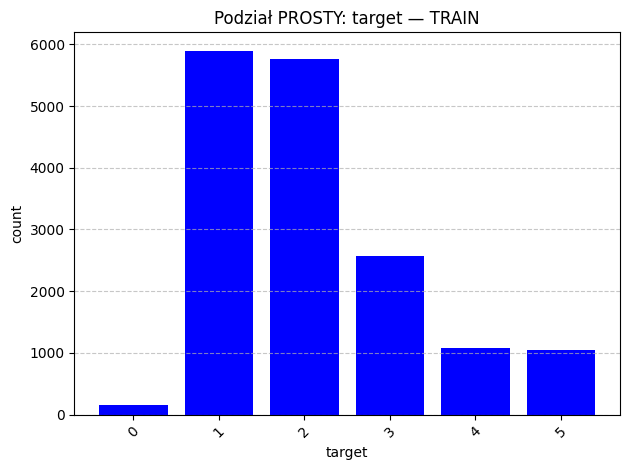

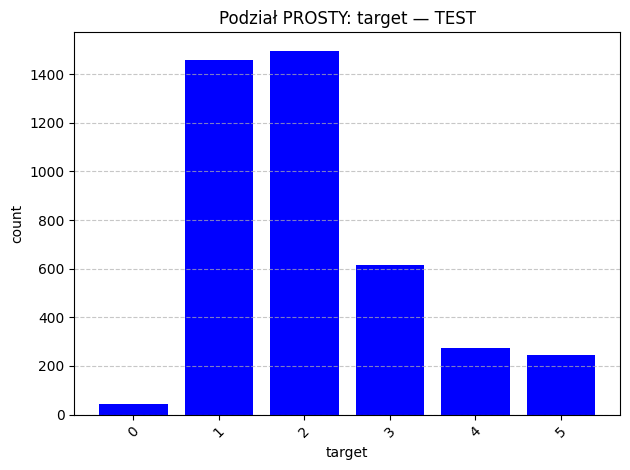

In [147]:
#wykresy dla prostego podziału
plot_hist(y_train_simple, "Podział PROSTY: target — TRAIN", ticks=True)
plot_hist(y_test_simple, "Podział PROSTY: target — TEST", ticks=True)

In [148]:
X_train_stratified, X_test_stratified, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train_final, y_val = train_test_split(y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

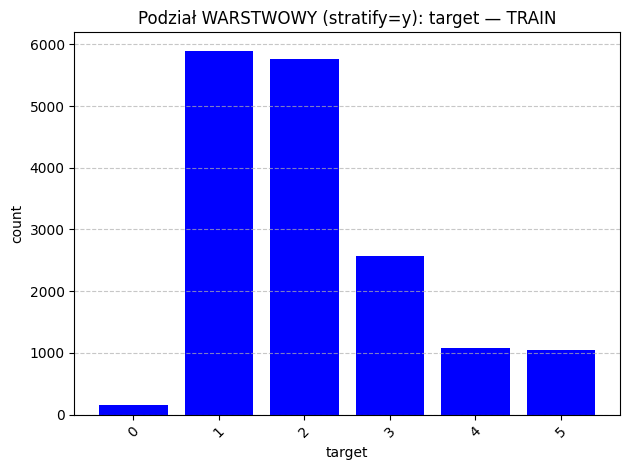

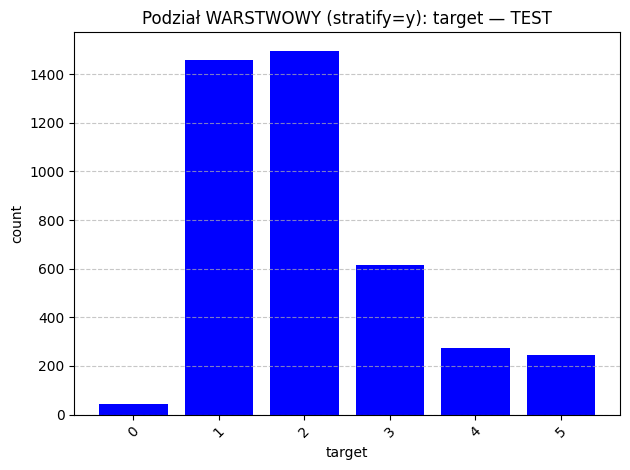

In [149]:
plot_hist(y_train_full, "Podział WARSTWOWY (stratify=y): target — TRAIN", ticks=True)
plot_hist(y_test, "Podział WARSTWOWY (stratify=y): target — TEST", ticks=True)

4. Dokonać podziału oryginalnego zbioru danych metodą warstwową względem innego atrybutu (obecnego w pierwotnej wersji zbioru). Jakiego atrybutu i dlaczego warto użyć? Dopuszczalne są niewielkie i uzasadnione zmiany wartości atrybutu stanowiącego źródło proporcji podziału.

In [151]:
#biore median_income (średni dochód gospodarstw domowych w danym obszarze) bo silnie koreluje z wartoscia domu
data = fetch_california_housing(as_frame=True).frame
data["income_cat"] = pd.cut(
    data["MedInc"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf], #przedziały dochodowe (5 kategorii dochodowych, żeby uzyskać reprezentatywne dane)
    labels=[1, 2, 3, 4, 5]
)

#splitter dla zachowania proporcji
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(data, data["income_cat"]):
    strat_train_set = data.iloc[train_idx]
    strat_test_set  = data.iloc[test_idx]


Histogramy do MedInc

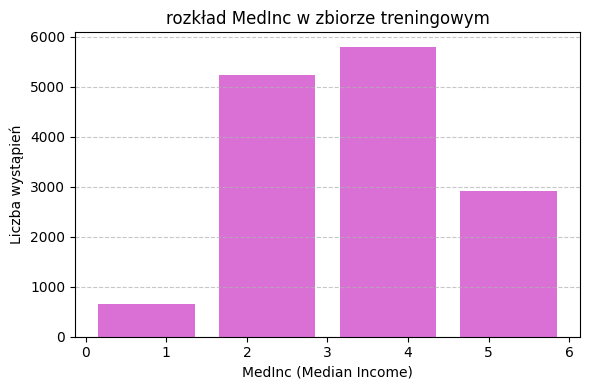

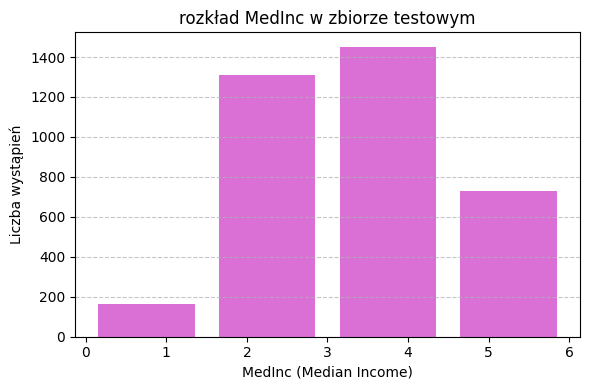

In [155]:
def plot_income_hist(df, title):
    plt.figure(figsize=(6, 4))
    plt.hist(df["MedInc"], bins=[0, 1.5, 3.0, 4.5, 6., np.inf], color="orchid", rwidth=0.8)
    plt.title(title)
    plt.xlabel("MedInc (Median Income)")
    plt.ylabel("Liczba wystąpień")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_income_hist(strat_train_set, "rozkład MedInc w zbiorze treningowym")
plot_income_hist(strat_test_set, "rozkład MedInc w zbiorze testowym")

In [156]:
#sprawdzamy czy proporcje zostały zachowane poprawnie = czy splitter zadziałał
def income_cat_proportions(data):
    return data["income_cat"].value_counts(normalize=True).sort_index()

print("Proporcje przed podziałem:")
print(income_cat_proportions(data))
print("\nProporcje w zbiorze treningowym:")
print(income_cat_proportions(strat_train_set))
print("\nProporcje w zbiorze testowym:")
print(income_cat_proportions(strat_test_set))

Proporcje przed podziałem:
income_cat
1    0.039826
2    0.318847
3    0.350581
4    0.176308
5    0.114438
Name: proportion, dtype: float64

Proporcje w zbiorze treningowym:
income_cat
1    0.039789
2    0.318859
3    0.350594
4    0.176296
5    0.114462
Name: proportion, dtype: float64

Proporcje w zbiorze testowym:
income_cat
1    0.039971
2    0.318798
3    0.350533
4    0.176357
5    0.114341
Name: proportion, dtype: float64


Różnice między podziałami są małe